<h1><center>Severity of Road Vehicle Collisions in Seattle</center></h1>

<h2>Introduction</h2>

   Road vehicle collisions affect the lives of countless people around the world every day. Not only do they harm people directly involved in the collisions, they also impact all members of the society by causing traffic congestion and putting strain on the public resources. 

   The objective of this project is to use supervised machine learning techniques to predict the severity of road vehicle collisions. Using a dataset of 194,673 collisions that occurred in Seattle from 2004 to 2020, I implement classification of collisions into two levels of severity - property damage and injury. The classification algorithms used in this study are K nearest neighbors (KNN) and Random Forest. 

   The results of this study will show which features of collisions help predict their severity and how they impact the outcome (severe vs. not severe). All members of our society - especially those drivers who want to avoid severe collisions - will be interested in the findings of this study. Also, the results will be of particular interest to government officials and city planners who are working to reduce the incidence of motor vehicle collisions.


<h2>Data</h2>

In this study, I used open data provided by the Seattle Police Department (SPD) and recorded by Traffic Records. The dataset used in this project is a subset of the original dataset, and it is made available for online learners [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv) (with [metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)). It includes 194,673 collisions that occurred between January 1, 2004 and May 20, 2020 in Seattle. There are two types of severity of collisions - “Injury Collision” and “Property Damage Only Collision”.

The dataset contains over 30 features of road vehicle collisions such as location, collision type, number of people involved, weather and road conditions. Some of them are likely to be more helpful in predicting the severity of collisions than others. I first perform exploratory data analysis to determine which features should be used for prediction.


<strong>Exploratory Data Analysis</strong>

First, the required libraries are loaded.

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The data is loaded from CSV file.

In [140]:
data = pd.read_csv('Data-Collisions.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [141]:
data.shape

(194673, 38)

In [142]:
data.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

How many collisions are in each class?

In [143]:
severity_counts = data['SEVERITYCODE'].value_counts()
severity_counts

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

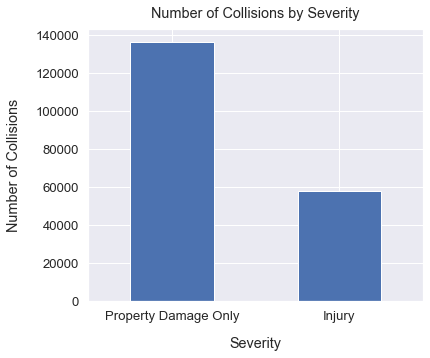

In [144]:
import seaborn as sns
sns.set(font_scale=1.2)
ax = data['SEVERITYCODE'].value_counts().plot(kind='bar', figsize=(6, 5), rot=0)
plt.xlabel("Severity", labelpad=14)
ax.set_xticklabels(['Property Damage Only', 'Injury'])
plt.ylabel("Number of Collisions", labelpad=14)
plt.title("Number of Collisions by Severity", y=1.02);

There are 136,485 "Property Damage Only Collisions" and 57,118 "Injury Collisions" in this dataset. The data is imbalanced (i.e. it has a disproportionate ratio of observations in each class) and it needs to be adjusted before it can be used for machine learning algorithms. Either up-sampling injury collisions or down-sampling property damage only collisions would work to balance the data.

In [145]:
data['Year'] = data['INCDATE'].astype(str).str[:4]

In [146]:
year_severity_counts = data.groupby(['Year','SEVERITYCODE','SEVERITYDESC']).size().reset_index(name='Count')

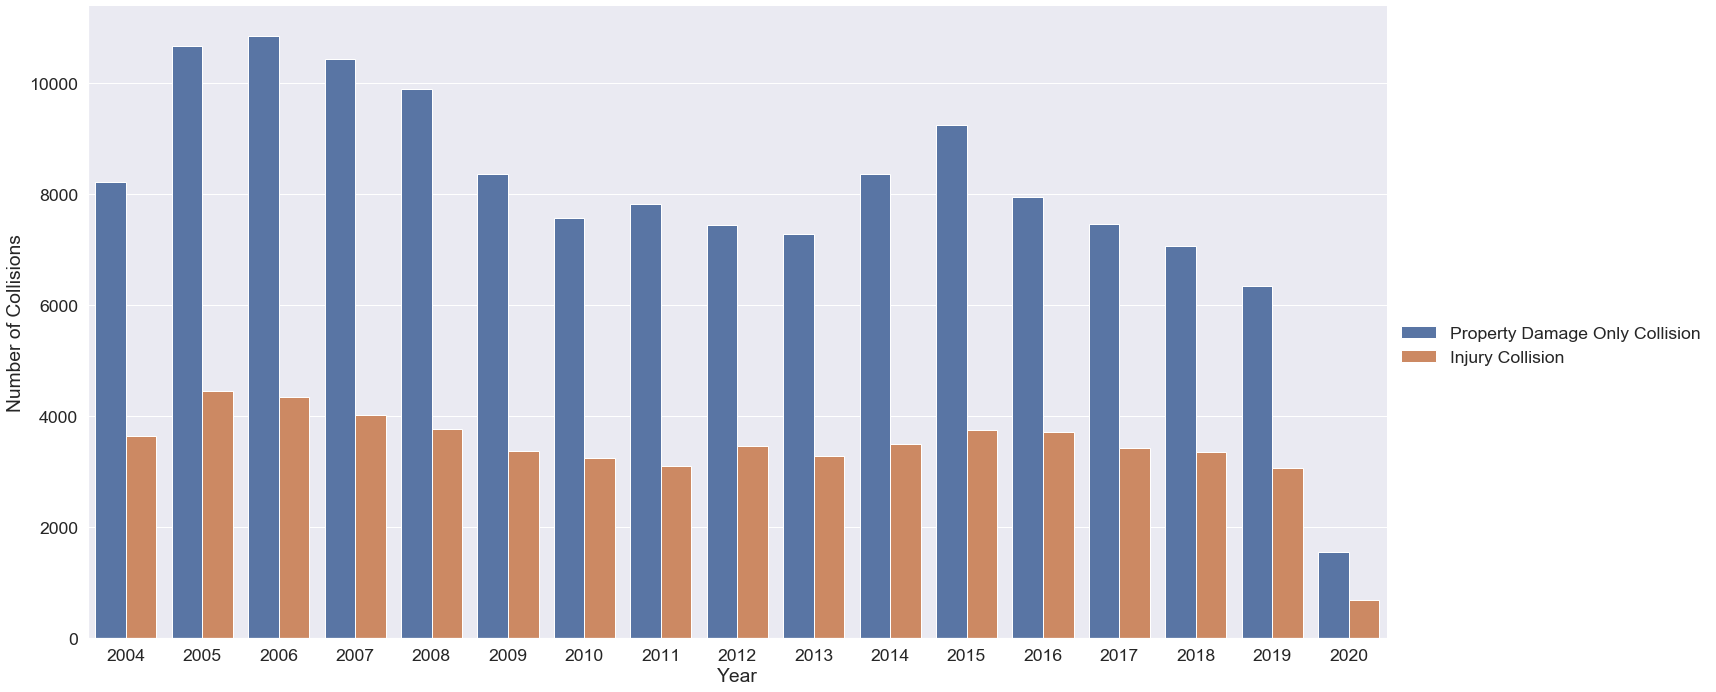

In [147]:
sns.set(font_scale=1.6)
year_graph = sns.catplot(x='Year', y='Count', hue='SEVERITYDESC', data=year_severity_counts, kind='bar', height=10, aspect=2)
year_graph._legend.set_title('')
year_graph.set(ylabel="Number of Collisions");

In [148]:
data['INCDATE'] = pd.to_datetime(data['INCDATE'])

In [149]:
data['dayofweek'] = data['INCDATE'].dt.dayofweek

In [150]:
data['dayofweek_desc'] = data['dayofweek']
data['dayofweek_desc'].replace(to_replace=[0,1,2,3,4,5,6], value=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],inplace=True)

In [151]:
dayofweek_severity_counts = data.groupby(['dayofweek','dayofweek_desc','SEVERITYCODE','SEVERITYDESC']).size().reset_index(name='Count')
dayofweek_severity_counts

,dayofweek,dayofweek_desc,SEVERITYCODE,SEVERITYDESC,Count
0,0,Mon,1,Property Damage Only Collision,18365
1,0,Mon,2,Injury Collision,7973
2,1,Tue,1,Property Damage Only Collision,19825
3,1,Tue,2,Injury Collision,8731
4,2,Wed,1,Property Damage Only Collision,20021
5,2,Wed,2,Injury Collision,8757
6,3,Thu,1,Property Damage Only Collision,20306
7,3,Thu,2,Injury Collision,9018
8,4,Fri,1,Property Damage Only Collision,22774
9,4,Fri,2,Injury Collision,9559


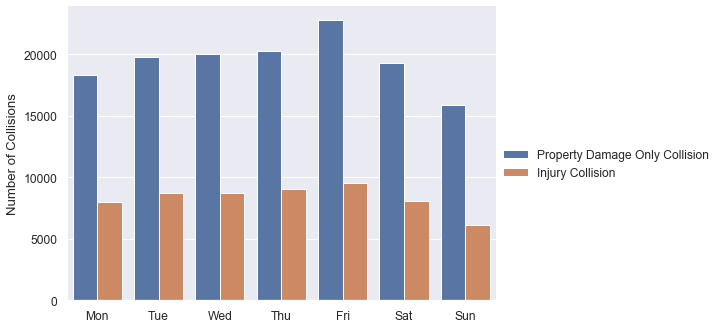

In [152]:
sns.set(font_scale=1.1)
dayofweek_graph = sns.catplot(x='dayofweek_desc', y='Count', hue='SEVERITYDESC', data=dayofweek_severity_counts, kind='bar', height=5, aspect=1.5)
dayofweek_graph._legend.set_title('')
dayofweek_graph.set(xlabel="", ylabel="Number of Collisions");

In [153]:
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)

In [154]:
data['weekend_desc'] = data['weekend']
data['weekend_desc'].replace(to_replace=[0,1], value=["Mon-Fri","Weekend"],inplace=True)

In [155]:
weekend_severity_counts = data.groupby(['weekend','weekend_desc','SEVERITYCODE','SEVERITYDESC']).size().reset_index(name='Count')

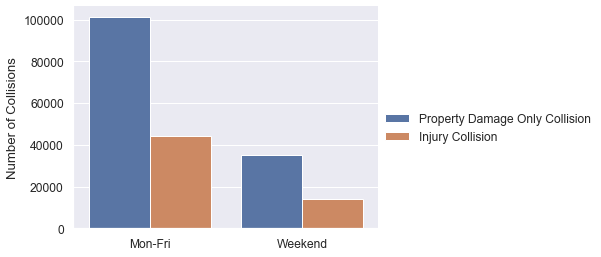

In [156]:
sns.set(font_scale=1.1)
weekend_graph = sns.catplot(x='weekend_desc', y='Count', hue='SEVERITYDESC', data=weekend_severity_counts, kind='bar', height=4, aspect=1.5)
weekend_graph._legend.set_title('')
weekend_graph.set(xlabel="", ylabel="Number of Collisions");

In [157]:
collisiontype_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','COLLISIONTYPE']).size().reset_index(name='Count')
collisiontype_severity_counts

,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,Count
0,1,Property Damage Only Collision,Angles,21050
1,1,Property Damage Only Collision,Cycles,671
2,1,Property Damage Only Collision,Head On,1152
3,1,Property Damage Only Collision,Left Turn,8292
4,1,Property Damage Only Collision,Other,17591
5,1,Property Damage Only Collision,Parked Car,45325
6,1,Property Damage Only Collision,Pedestrian,672
7,1,Property Damage Only Collision,Rear Ended,19419
8,1,Property Damage Only Collision,Right Turn,2347
9,1,Property Damage Only Collision,Sideswipe,16103


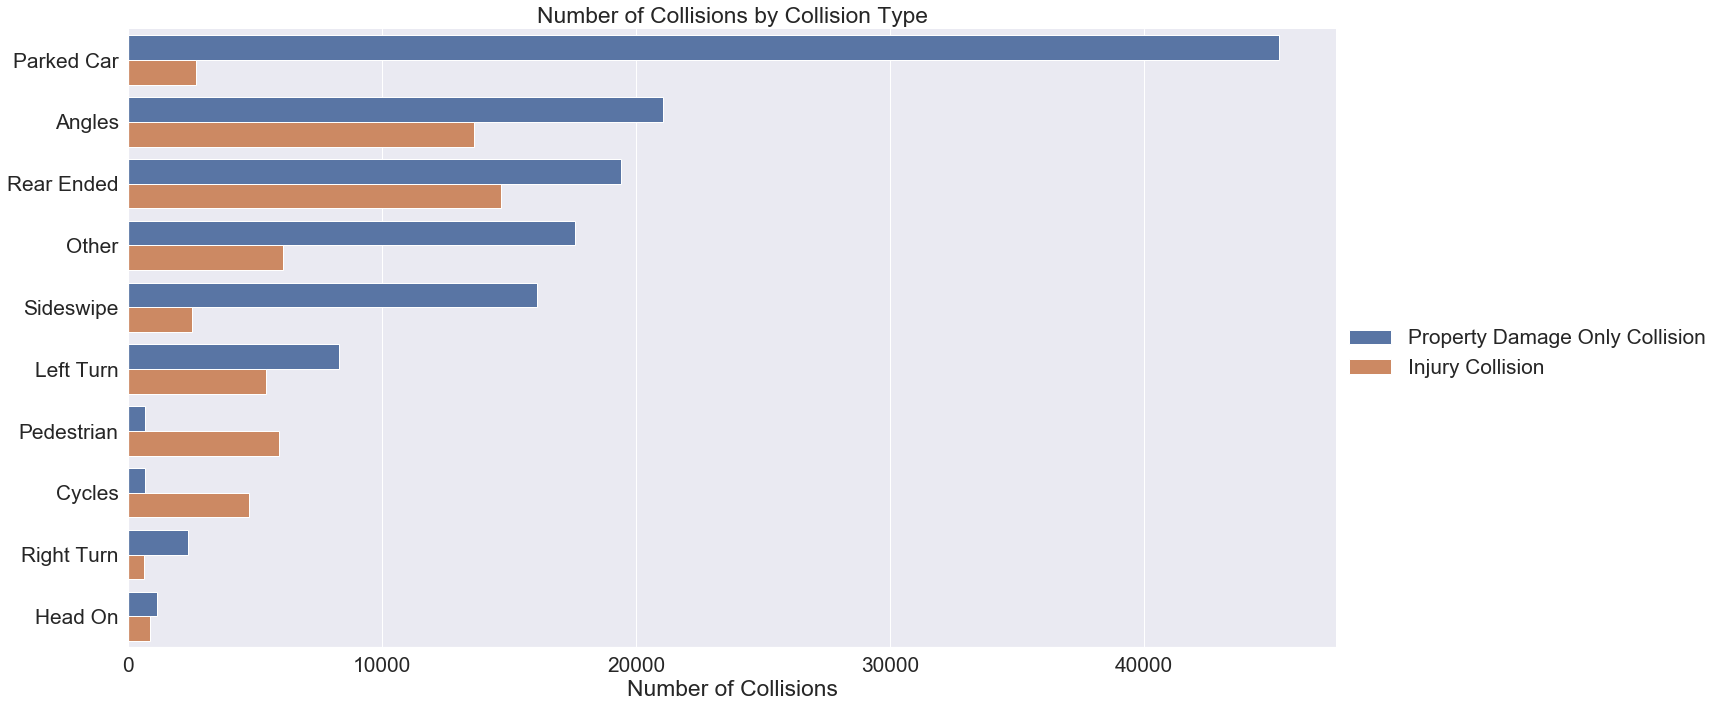

In [158]:
sns.set(font_scale=1.9)
collisiontype_graph = sns.catplot(x='Count', y='COLLISIONTYPE', hue='SEVERITYDESC', data=collisiontype_severity_counts, kind='bar', order=data['COLLISIONTYPE'].value_counts().index, height=10, aspect=2)
collisiontype_graph._legend.set_title('')
collisiontype_graph.set(xlabel="Number of Collisions", ylabel="")
plt.title('Number of Collisions by Collision Type');

In [159]:
addrtype_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','ADDRTYPE']).size().reset_index(name='Count')
addrtype_severity_counts

,SEVERITYCODE,SEVERITYDESC,ADDRTYPE,Count
0,1,Property Damage Only Collision,Alley,669
1,1,Property Damage Only Collision,Block,96830
2,1,Property Damage Only Collision,Intersection,37251
3,2,Injury Collision,Alley,82
4,2,Injury Collision,Block,30096
5,2,Injury Collision,Intersection,27819


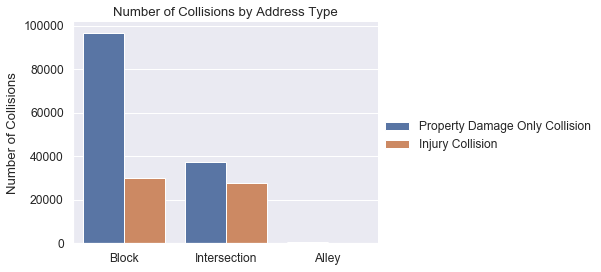

In [160]:
sns.set(font_scale=1.1)
addrtype_graph = sns.catplot(x='ADDRTYPE', y='Count', hue='SEVERITYDESC', data=addrtype_severity_counts, kind='bar', order=data['ADDRTYPE'].value_counts().index, height=4, aspect=1.5)
addrtype_graph._legend.set_title('')
addrtype_graph.set(ylabel="Number of Collisions", xlabel="")
plt.title('Number of Collisions by Address Type');

As the graph above shows, the collision address type (alley, block or intersection) is associated with the severity of collisions. Injury collisions are more likely to occur at intersections than blocks or alleyways.

In [161]:
junctiontype_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','JUNCTIONTYPE']).size().reset_index(name='Count')
junctiontype_severity_counts

,SEVERITYCODE,SEVERITYDESC,JUNCTIONTYPE,Count
0,1,Property Damage Only Collision,At Intersection (but not related to intersection),1475
1,1,Property Damage Only Collision,At Intersection (intersection related),35636
2,1,Property Damage Only Collision,Driveway Junction,7437
3,1,Property Damage Only Collision,Mid-Block (but intersection related),15493
4,1,Property Damage Only Collision,Mid-Block (not related to intersection),70396
5,1,Property Damage Only Collision,Ramp Junction,112
6,1,Property Damage Only Collision,Unknown,7
7,2,Injury Collision,At Intersection (but not related to intersection),623
8,2,Injury Collision,At Intersection (intersection related),27174
9,2,Injury Collision,Driveway Junction,3234


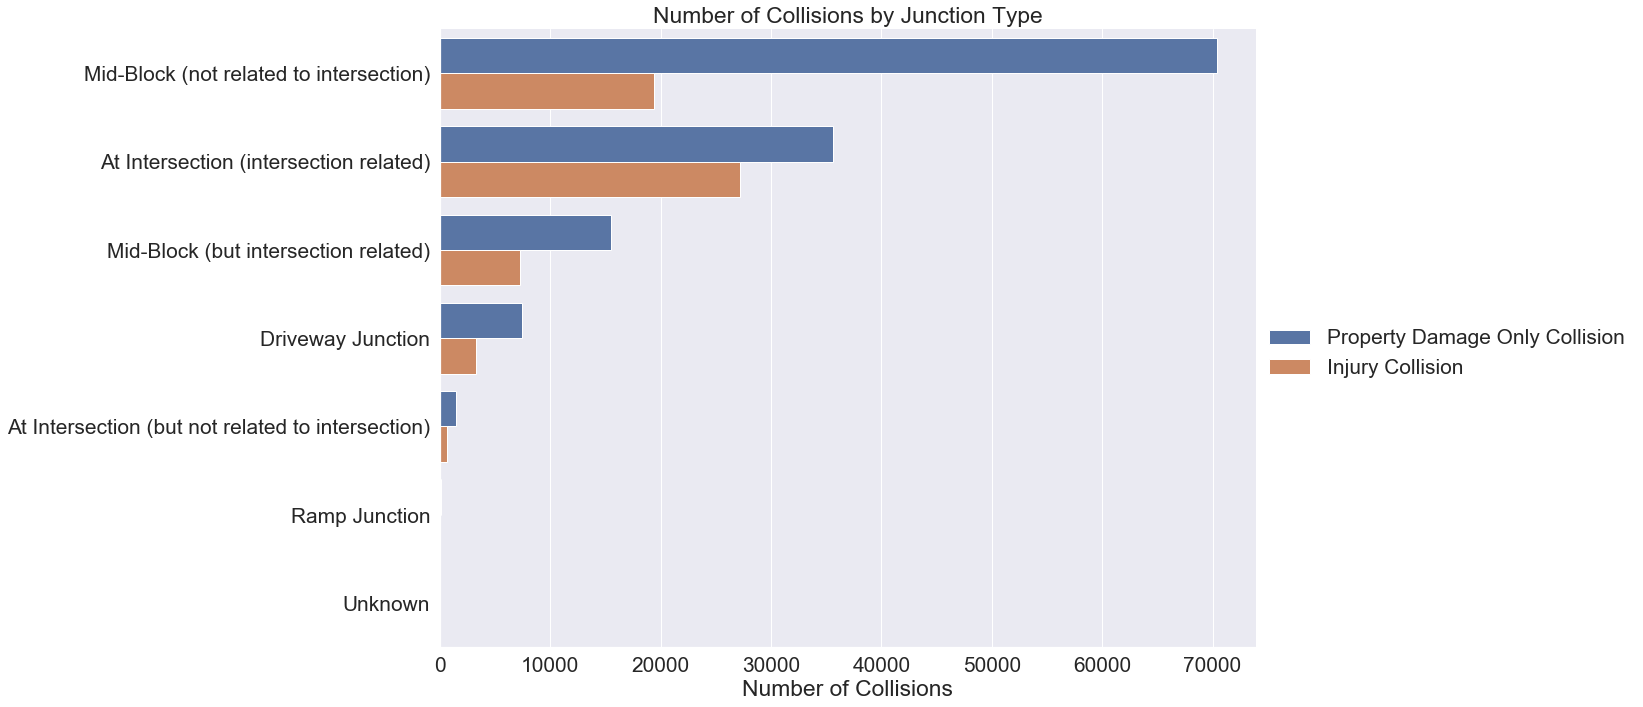

In [162]:
sns.set(font_scale=1.9)
junctiontype_graph = sns.catplot(x='Count', y='JUNCTIONTYPE', hue='SEVERITYDESC', data=junctiontype_severity_counts, kind='bar', order=data['JUNCTIONTYPE'].value_counts().index, height=10, aspect=2)
junctiontype_graph._legend.set_title('')
junctiontype_graph.set(xlabel="Number of Collisions", ylabel="")
plt.title('Number of Collisions by Junction Type');

Severe collisions that cause injuries are more likely to occur at intersections than mid-block or driveways.

In [163]:
data['INATTENTIONIND'].value_counts()

Y    29805
Name: INATTENTIONIND, dtype: int64

In [164]:
inattention_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','INATTENTIONIND']).size().reset_index(name='Count')

We can calculate the percentage of total collisions that were due to inattention for the two severity levels.

| Severity | Inattention | Total |% Inattention|
|------|------|||
| Property Damage Only Collision  | 19,408|136,486|14.2%|
| Injury Collision  | 10,397|57,118|18.2%|


In [165]:
data['UNDERINFL'].value_counts().sort_index()

0     80394
1      3995
N    100274
Y      5126
Name: UNDERINFL, dtype: int64

It looks like the column "UNDERINFL" (Whether or not a driver involved was under the influence of drugs or alcohol) needs to be cleaned. Replace Y with 1, and N with 0.

In [166]:
data['UNDERINFL_2'] = data['UNDERINFL']
data['UNDERINFL_2'].replace(to_replace=["Y","N","1","0"], value=[int(1),int(0),int(1),int(0)],inplace=True)
data['UNDERINFL_DESC'] = data['UNDERINFL_2']
data['UNDERINFL_DESC'].replace(to_replace=[1,0], value=['Influence','No influence'], inplace=True)

In [167]:
underinfl_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','UNDERINFL_DESC']).size().reset_index(name='Count')
underinfl_severity_counts

,SEVERITYCODE,SEVERITYDESC,UNDERINFL_DESC,Count
0,1,Property Damage Only Collision,Influence,5559
1,1,Property Damage Only Collision,No influence,127071
2,2,Injury Collision,Influence,3562
3,2,Injury Collision,No influence,53597


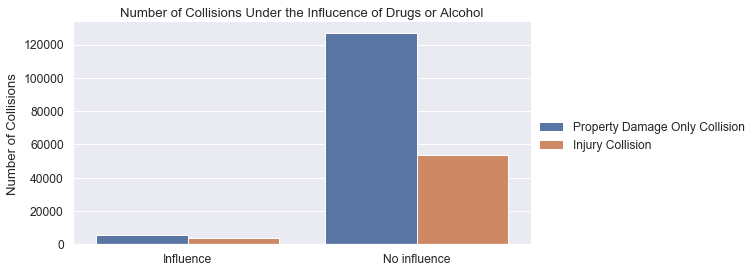

In [168]:
sns.set(font_scale=1.1)
underinfl_graph = sns.catplot(x='UNDERINFL_DESC', y='Count', hue='SEVERITYDESC', data=underinfl_severity_counts, kind='bar', height=4, aspect=2)
underinfl_graph._legend.set_title('')
underinfl_graph.set(xlabel="", ylabel="Number of Collisions")
plt.title("Number of Collisions Under the Influcence of Drugs or Alcohol");

In [169]:
weather_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','WEATHER']).size().reset_index(name='Count')
weather_severity_counts

,SEVERITYCODE,SEVERITYDESC,WEATHER,Count
0,1,Property Damage Only Collision,Blowing Sand/Dirt,41
1,1,Property Damage Only Collision,Clear,75295
2,1,Property Damage Only Collision,Fog/Smog/Smoke,382
3,1,Property Damage Only Collision,Other,716
4,1,Property Damage Only Collision,Overcast,18969
5,1,Property Damage Only Collision,Partly Cloudy,2
6,1,Property Damage Only Collision,Raining,21969
7,1,Property Damage Only Collision,Severe Crosswind,18
8,1,Property Damage Only Collision,Sleet/Hail/Freezing Rain,85
9,1,Property Damage Only Collision,Snowing,736


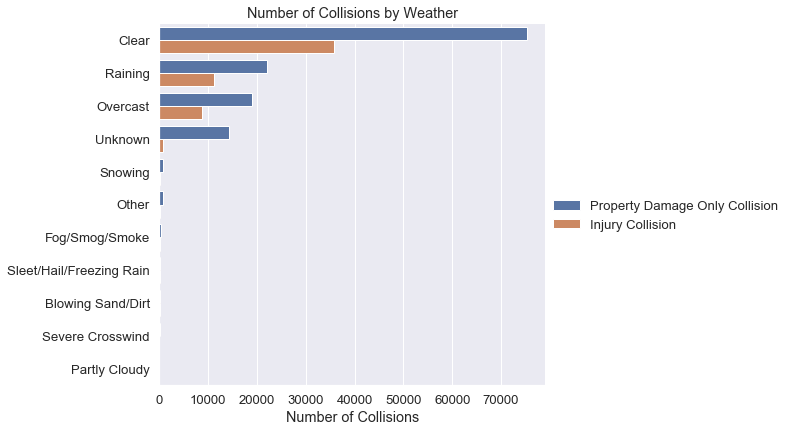

In [170]:
sns.set(font_scale=1.2)
weather_graph = sns.catplot(x='Count', y='WEATHER', hue='SEVERITYDESC', data=weather_severity_counts, kind='bar', order=data['WEATHER'].value_counts().index, height=6, aspect=1.5)
weather_graph._legend.set_title('')
weather_graph.set(xlabel="Number of Collisions", ylabel="")
plt.title("Number of Collisions by Weather");

In [171]:
roadcond_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','ROADCOND']).size().reset_index(name='Count')
roadcond_severity_counts

,SEVERITYCODE,SEVERITYDESC,ROADCOND,Count
0,1,Property Damage Only Collision,Dry,84446
1,1,Property Damage Only Collision,Ice,936
2,1,Property Damage Only Collision,Oil,40
3,1,Property Damage Only Collision,Other,89
4,1,Property Damage Only Collision,Sand/Mud/Dirt,52
5,1,Property Damage Only Collision,Snow/Slush,837
6,1,Property Damage Only Collision,Standing Water,85
7,1,Property Damage Only Collision,Unknown,14329
8,1,Property Damage Only Collision,Wet,31719
9,2,Injury Collision,Dry,40064


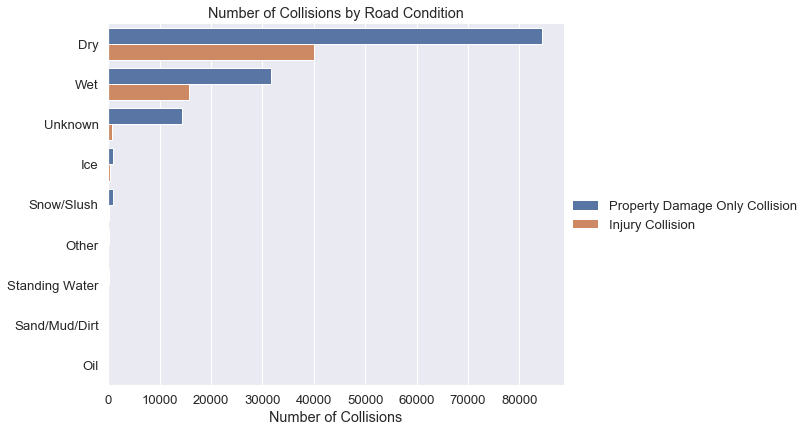

In [172]:
sns.set(font_scale=1.2)
roadcond_graph = sns.catplot(x='Count', y='ROADCOND', hue='SEVERITYDESC', data=roadcond_severity_counts, kind='bar', order=data['ROADCOND'].value_counts().index, height=6, aspect=1.5)
roadcond_graph._legend.set_title('')
roadcond_graph.set(xlabel="Number of Collisions", ylabel="")
plt.title("Number of Collisions by Road Condition");

In [173]:
lightcond_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','LIGHTCOND']).size().reset_index(name='Count')
lightcond_severity_counts

,SEVERITYCODE,SEVERITYDESC,LIGHTCOND,Count
0,1,Property Damage Only Collision,Dark - No Street Lights,1203
1,1,Property Damage Only Collision,Dark - Street Lights Off,883
2,1,Property Damage Only Collision,Dark - Street Lights On,34032
3,1,Property Damage Only Collision,Dark - Unknown Lighting,7
4,1,Property Damage Only Collision,Dawn,1678
5,1,Property Damage Only Collision,Daylight,77593
6,1,Property Damage Only Collision,Dusk,3958
7,1,Property Damage Only Collision,Other,183
8,1,Property Damage Only Collision,Unknown,12868
9,2,Injury Collision,Dark - No Street Lights,334


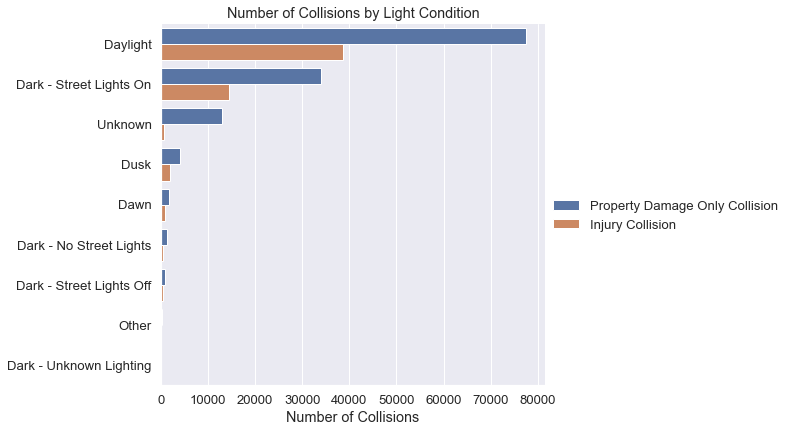

In [174]:
sns.set(font_scale=1.2)
roadcond_graph = sns.catplot(x='Count', y='LIGHTCOND', hue='SEVERITYDESC', data=lightcond_severity_counts, kind='bar', order=data['LIGHTCOND'].value_counts().index, height=6, aspect=1.5)
roadcond_graph._legend.set_title('')
roadcond_graph.set(xlabel="Number of Collisions", ylabel="")
plt.title("Number of Collisions by Light Condition");

In [175]:
data['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

In [176]:
speeding_severity_counts = data.groupby(['SEVERITYCODE','SEVERITYDESC','SPEEDING']).size().reset_index(name='Count')

We can calculate the percentage of total collisions that were due to speeding for the two severity levels.

| Severity | Speeding | Total |% Speeding|
|------|------|||
| Property Damage Only Collision  | 5,802|136,486|4.25%|
| Injury Collision  | 3,531|57,118|6.18%|


Based on the exploratory data analysis, the features that are likely to be the best ones for machine learning algorithms are: weekend, collision address type, weather, road condition, and speeding. 